In [25]:
#import numpy as np
#from numpy import float32
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

import sklearn
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras

tf.config.run_functions_eagerly(True)

# Configure GPU memory growth to avoid ResourceExhaustedError
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Limit CPU memory usage
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)

import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
#from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn import metrics
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from numpy import float32

In [3]:
df = pd.read_csv("pmbc_scaled2.csv", header=None, index_col=0, skiprows=1, encoding='latin-1').T

In [4]:
df.head()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2.1,SRSF10.1
1,-0.058123,-0.033576,-0.041668,-0.033646,-0.08224,-0.317171,-0.053447,-0.050822,-0.033088,-0.233768,...,-0.405417,1.072036,0.607943,-0.31224,0.244998,-0.073893,-0.360356,-0.052402,-0.203856,-0.159349
2,-0.058123,-0.033576,-0.041668,-0.033646,-0.08224,-0.317171,-0.053447,-0.050822,-0.033088,-0.233768,...,-0.405417,1.647420,0.099620,-0.31224,0.231536,-0.073893,1.553801,-0.052402,-0.203856,-0.159349
3,-0.058123,-0.033576,-0.041668,-0.033646,-0.08224,-0.317171,-0.053447,-0.050822,-0.033088,-0.233768,...,-0.405417,-0.601650,0.956623,-0.31224,-0.018325,-0.073893,-0.360356,-0.052402,-0.203856,-0.159349
4,-0.058123,-0.033576,-0.041668,-0.033646,-0.08224,-0.317171,-0.053447,-0.050822,-0.033088,-0.233768,...,2.147842,-0.408436,1.105834,-0.31224,-0.520072,-0.073893,-0.360356,-0.052402,-0.203856,-0.159349
5,-0.058123,-0.033576,-0.041668,-0.033646,-0.08224,-0.317171,-0.053447,-0.050822,-0.033088,-0.233768,...,-0.405417,-3.434207,1.992704,-0.31224,-0.234357,-0.073893,-0.360356,-0.052402,-0.203856,-0.159349


In [5]:
df.shape

(2638, 13714)

In [6]:
x_train = df

In [7]:
x_train = np.asarray(df).astype('float32')
# Reshape for the model: (samples, features, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [8]:
class Sampling(keras.layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def create_network(latent_dim = 9):
    # Building the encoder - reduced model size to prevent memory issues
    encoder_inputs = keras.Input(shape=(13714,1))
    x = keras.layers.Flatten()(encoder_inputs)
    x = keras.layers.Dense(512, activation = "relu")(x)  # Reduced from 1000
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(rate=0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256, activation = "relu")(x)  # Reduced from 500
    x = keras.layers.Dropout(rate=0.5)(x)
    x = keras.layers.Dense(64, activation = "relu")(x)  # Reduced from 100
    z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    # Now do the same for the decoder - reduced model size
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = keras.layers.Dense(64, activation="relu")(latent_inputs)  # Reduced from 100
    x = keras.layers.Dense(256, activation = "relu")(x)  # Reduced from 500
    x = keras.layers.Dense(512, activation = "relu")(x)  # Reduced from 1000
    x = keras.layers.Dense(13714, activation="sigmoid")(x)
    decoder_outputs = keras.layers.Reshape((13714,1))(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return (encoder, decoder)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            '''
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=1
                )
            )
            '''
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) 
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
models = {}
def vae_fit(i):
  # Clear any previous models from memory
  import gc
  gc.collect()
  
  model = create_network(latent_dim = i)
  vae = VAE(model[0], model[1])
  vae.compile(optimizer=keras.optimizers.Adam())
  # Further reduce batch size to avoid memory issues
  vae.fit(x_train, epochs=50, batch_size=16, verbose=1)
  
  # Save models with .keras extension
  os.makedirs('saved_models/eeg', exist_ok=True)
  encoder_path = f'saved_models/eeg/vae_encoder_{i}.keras'
  decoder_path = f'saved_models/eeg/vae_decoder_{i}.keras'
  vae.encoder.save(encoder_path)
  vae.decoder.save(decoder_path)
  
  # Store only essential info, not full model to save memory
  models[i] = vae
  return vae

'\ndef knn_predict(model, num):\n    z = model.encoder.predict(np.array([x_train[0]]))\n    print(len(z), np.array(z[0]).shape)\n    print(z[0], z[0][0])\n    z_train = [model.encoder.predict(np.array([x]))[0][0] for x in x_train]\n    z_test = [model.encoder.predict(np.array([x]))[0][0] for x in x_test]\n    # Do K-mean clustering\n    # Calculate clustering score\n    knn = KNeighborsClassifier(n_neighbors=1)\n    knn.fit(z_train,y_train)\n    predicted = knn.predict(z_test)\n    errors = 0\n    c_matrix = [[0 for i in range(5)] for i in range(5)]\n    for i in range(len(z_test)):\n      c_matrix[int(predicted[i]) -1][int(y_test[i]) - 1] += 1\n      if predicted[i] != y_test[i]:\n        errors += 1\n    print("errors:", errors, len(z_test), errors/len(z_test))\n    plt.figure()\n    seaborn.heatmap(c_matrix, annot = True)\n    plt.xlabel("True Values")\n    plt.ylabel("Predicted Values")\n    plt.savefig("confusion_matrix_" + str(num) + ".png")\n    return 1 - errors/len(z_test)\n'

In [12]:
n = 10 #tests from 1, ..., n - 1

losses = []
accuracies = []
for i in range(1,n):
    try:
        vae = vae_fit(i)
        losses.append(vae.kl_loss_tracker.result())
        #accuracy = knn_predict(vae, i)
        #accuracies.append(accuracy)
        print(f"Model {i} completed. Loss: {vae.kl_loss_tracker.result():.4f}")
        print(f"Current losses: {losses}")
        
        # Clear memory after each model
        import gc
        import tensorflow as tf
        tf.keras.backend.clear_session()
        gc.collect()
    except Exception as e:
        print(f"Error training model {i}: {e}")
        break

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 1)         │         65 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 1)         │         65 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 1)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,082 (27.37 MB)

 Trainable params: 7,172,034 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,183,634 (27.40 MB)

 Trainable params: 7,183,634 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 0.8503
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 0.8502
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 0.8503
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 0.8501
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 0.8503
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 0.8504
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 0.8501
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - kl_loss: 0.8501
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 0.8503
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 0.8501
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 0.8505
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 0.8500
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 0.8501
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - kl_loss: 0.8504
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        130 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        130 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,212 (27.37 MB)

 Trainable params: 7,172,164 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,183,698 (27.40 MB)

 Trainable params: 7,183,698 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 1.3247
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.3240
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.3242
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 1.3239
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - kl_loss: 1.3243
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 1.3241
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 1.3242
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - kl_loss: 1.3242
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - kl_loss: 1.3242
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 1.3244
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 1.3239
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.3241
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 1.3239
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.3243
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │        195 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │        195 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,342 (27.37 MB)

 Trainable params: 7,172,294 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,183,762 (27.40 MB)

 Trainable params: 7,183,762 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.1010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - kl_loss: 2.1007
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.1017
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.1009
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 2.1011
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - kl_loss: 2.1008
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - kl_loss: 2.1006
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 2.1009
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 2.1007
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - kl_loss: 2.1012
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.1007
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.1008
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.1008
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.1005
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 4)         │        260 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 4)         │        260 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 4)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,472 (27.37 MB)

 Trainable params: 7,172,424 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,183,826 (27.40 MB)

 Trainable params: 7,183,826 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9516
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9517
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 1.9519
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - kl_loss: 1.9519
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - kl_loss: 1.9516
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9516
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9515
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - kl_loss: 1.9513
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9519
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9516
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9519
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9518
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9518
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 1.9518
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 5)         │        325 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 5)         │        325 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 5)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,602 (27.37 MB)

 Trainable params: 7,172,554 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,183,890 (27.40 MB)

 Trainable params: 7,183,890 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.2251
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.2241
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 2.2247
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.2249
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.2246
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - kl_loss: 2.2248
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.2249
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.2251
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.2247
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 2.2244
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.2246
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.2247
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 2.2250
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 2.2251
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 6)         │        390 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 6)         │        390 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 6)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,732 (27.37 MB)

 Trainable params: 7,172,684 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,183,954 (27.40 MB)

 Trainable params: 7,183,954 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - kl_loss: 2.8245
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.8248
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 2.8248
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 2.8250
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 2.8242
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.8247
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 2.8248
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 2.8250
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - kl_loss: 2.8245
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - kl_loss: 2.8248
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 2.8251
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 2.8244
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.8249
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - kl_loss: 2.8247
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 7)         │        455 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 7)         │        455 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 7)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,862 (27.37 MB)

 Trainable params: 7,172,814 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,184,018 (27.40 MB)

 Trainable params: 7,184,018 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - kl_loss: 2.0588
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 2.0588
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 2.0591
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 2.0590
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - kl_loss: 2.0592
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - kl_loss: 2.0588
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 2.0593
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.0589
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 2.0589
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.0589
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.0591
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.0588
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 2.0587
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 2.0592
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │        520 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │        520 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,174,992 (27.37 MB)

 Trainable params: 7,172,944 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,184,082 (27.41 MB)

 Trainable params: 7,184,082 (27.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2340
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2336
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2342
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - kl_loss: 4.2336
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2340
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2333
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 4.2336
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - kl_loss: 4.2337
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2337
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2338
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2344
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2338
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 4.2347
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - kl_loss: 4.2342
E

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13714, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 13714)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  7,022,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 9)         │        585 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 9)         │        585 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 9)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,175,122 (27.37 MB)

 Trainable params: 7,173,074 (27.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13714)          │     7,035,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13714, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,184,146 (27.41 MB)

 Trainable params: 7,184,146 (27.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 9.2460
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 9.2444
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2453
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 9.2454
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2460
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 9.2468
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - kl_loss: 9.2457
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2459
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2451
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2459
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 9.2451
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 9.2447
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2462
Epoch 14/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - kl_loss: 9.2452
E

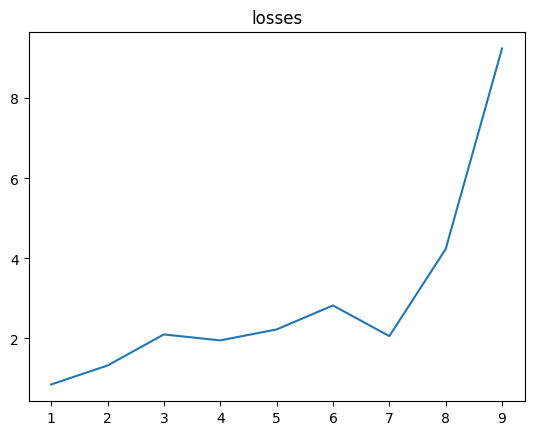

In [ ]:
plt.figure()
plt.plot(list(range(1,n)), losses)
plt.title("losses")
plt.savefig('losses.png')
plt.show()

In [14]:
# Use batch prediction to avoid memory issues
z_mean, _ , _ = models[2].encoder.predict(x_train, batch_size=32)

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [15]:
z_mean.shape

(2638, 2)

In [16]:
print(z_mean[:,0])

[-0.5197306  -1.5565171  -1.0763657  ... -0.9172157  -1.231836
 -0.33320886]


In [17]:
print(z_mean[:,1])

[0.97610307 0.52850604 0.4697736  ... 0.36999986 0.3866573  1.55712   ]


In [19]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(z_mean)
agg = AgglomerativeClustering(n_clusters=9, metric='euclidean').fit(z_mean)

In [30]:
import umap.umap_ as umap

In [32]:
# UMAP compatibility workaround: Use t-SNE as alternative or try UMAP with error handling
# The ensure_all_finite parameter issue is due to version incompatibility between umap-learn and scikit-learn

from sklearn.manifold import TSNE
import warnings

# Clean data
z_mean_clean = np.nan_to_num(np.asarray(z_mean), nan=0.0, posinf=1e6, neginf=-1e6)

# Try UMAP first, fall back to t-SNE if it fails
try:
    # Attempt to patch check_array more aggressively
    from sklearn.utils.validation import check_array as orig_check_array
    import functools
    
    def patched_check_array(*args, **kwargs):
        kwargs.pop('ensure_all_finite', None)
        return orig_check_array(*args, **kwargs)
    
    # Patch before importing/reloading
    import sklearn.utils.validation
    sklearn.utils.validation.check_array = patched_check_array
    
    # Try UMAP
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        standard_embedding = umap.UMAP(n_neighbors=20, min_dist=1, n_components=2, random_state=42).fit_transform(z_mean_clean)
    print("Used UMAP for dimensionality reduction")
except (TypeError, AttributeError) as e:
    print(f"UMAP failed ({e}), using t-SNE instead")
    # Fall back to t-SNE
    standard_embedding = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(z_mean_clean)
    print("Used t-SNE for dimensionality reduction")

UMAP failed (check_array() got an unexpected keyword argument 'ensure_all_finite'), using t-SNE instead
Used t-SNE for dimensionality reduction


Cluster Information:

Cluster 0:
  Size: 202 cells
  Sample cells: 6, 21, 31, 46, 52, ... (202 total)
  Top features: SULT1A1, FCN1, CFD

Cluster 1:
  Size: 364 cells
  Sample cells: 38, 41, 51, 56, 60, ... (364 total)
  Top features: SLC9A9, TOB1, G6PC3

Cluster 2:
  Size: 223 cells
  Sample cells: 12, 15, 25, 27, 30, ... (223 total)
  Top features: NUP98, ABL2, SAR1A

Cluster 3:
  Size: 265 cells
  Sample cells: 2, 5, 7, 9, 20, ... (265 total)
  Top features: NBPF12, PPP1R8, TYMP

Cluster 4:
  Size: 333 cells
  Sample cells: 11, 13, 33, 37, 50, ... (333 total)
  Top features: TMEM184C, TRAF6, SH3KBP1

Cluster 5:
  Size: 163 cells
  Sample cells: 23, 85, 141, 147, 154, ... (163 total)
  Top features: RLIM, FCER1A, PPP2R1A

Cluster 6:
  Size: 416 cells
  Sample cells: 1, 4, 8, 17, 22, ... (416 total)
  Top features: PLOD3, TMSB10, TRAF3IP3

Cluster 7:
  Size: 206 cells
  Sample cells: 14, 29, 47, 53, 59, ... (206 total)
  Top features: PDCD11, MZT2A, CALU

Cluster 8:
  Size: 466 cells


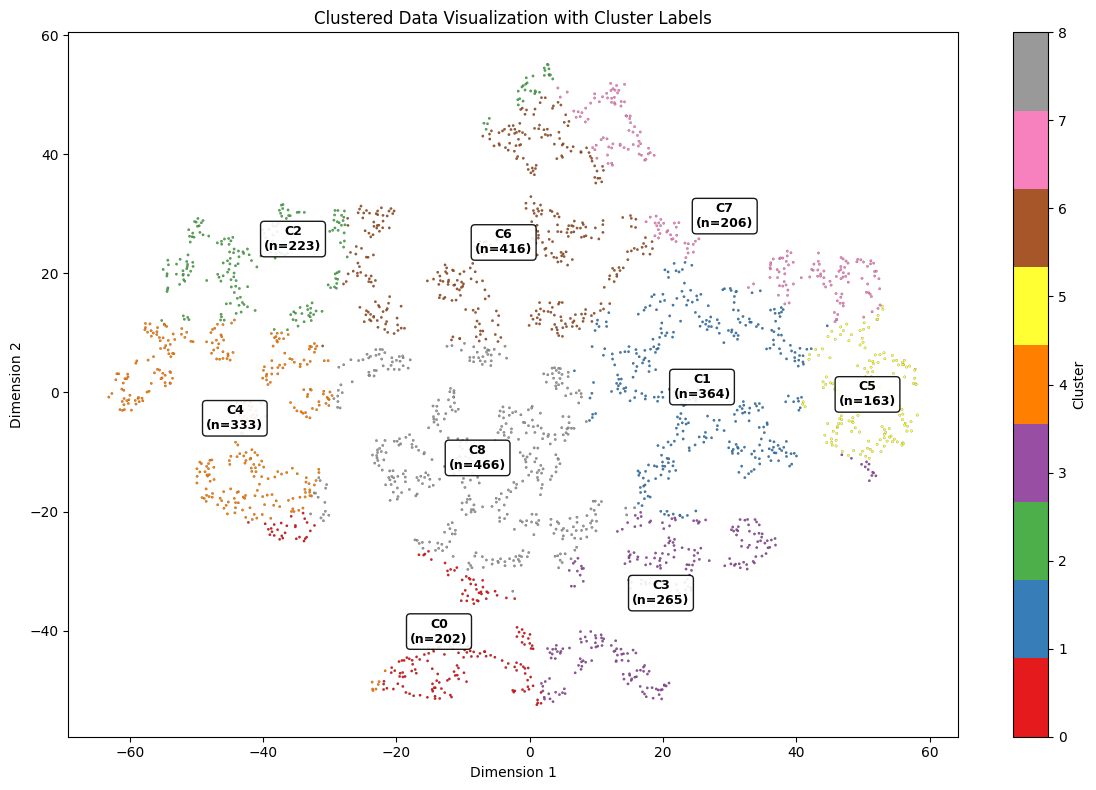

In [41]:
plt.figure(figsize=(12, 8))
# Use a darker colormap with more vibrant, opaque colors
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans.labels_, s=3, cmap='Set1', alpha=1.0, edgecolors='black', linewidths=0.1)

# Get cell names and genes if available
cell_names = df.index.values if hasattr(df, 'index') else None
genes = np.array(list(df.columns)) if hasattr(df, 'columns') else None

# Analyze clusters and add labels
print("Cluster Information:")
print("=" * 80)

# Store all top features data for DataFrame
all_top_features = []

for i in range(len(np.unique(kmeans.labels_))):
    # Find points belonging to this cluster
    cluster_mask = kmeans.labels_ == i
    cluster_points = standard_embedding[cluster_mask]
    cluster_size = np.sum(cluster_mask)
    
    # Calculate centroid
    centroid = cluster_points.mean(axis=0)
    
    # Get cell names in this cluster
    cluster_cells = []
    if cell_names is not None and len(cell_names) == len(kmeans.labels_):
        cluster_cells = cell_names[cluster_mask].tolist()
        # Convert to strings and show first few cell names
        cell_display = ', '.join(str(cell) for cell in cluster_cells[:5])
        if len(cluster_cells) > 5:
            cell_display += f', ... ({len(cluster_cells)} total)'
    else:
        cell_display = f"{cluster_size} cells"
    
    # Find most important features (genes) for this cluster
    top_features = []
    top_features_data = []  # Store feature name and fold change
    if genes is not None and hasattr(df, 'values'):
        # Calculate mean expression for this cluster vs all other clusters
        cluster_data = df.values[cluster_mask]
        other_data = df.values[~cluster_mask]
        
        if len(cluster_data) > 0 and len(other_data) > 0:
            cluster_mean = cluster_data.mean(axis=0)
            other_mean = other_data.mean(axis=0)
            # Calculate fold change (absolute difference)
            fold_change = np.abs(cluster_mean - other_mean)
            # Get top 10 most differentially expressed genes
            top_indices = np.argsort(fold_change)[-10:][::-1]
            top_features = [genes[idx] for idx in top_indices if idx < len(genes)]
            # Store feature names with their fold change values
            for idx in top_indices:
                if idx < len(genes):
                    top_features_data.append({
                        'cluster': i,
                        'feature': genes[idx],
                        'fold_change': fold_change[idx]
                    })
            # Add to master list
            all_top_features.extend(top_features_data)
    
    # Print cluster information
    print(f"\nCluster {i}:")
    print(f"  Size: {cluster_size} cells")
    print(f"  Sample cells: {cell_display}")
    if top_features:
        print(f"  Top features: {', '.join(top_features[:3])}")  # Show first 3 in print
    
    # Add label on plot (simplified to avoid clutter)
    plt.text(centroid[0], centroid[1], f'C{i}\n(n={cluster_size})', 
             fontsize=9, fontweight='bold', ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustered Data Visualization with Cluster Labels')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)

In [42]:
# Create DataFrame with top features
if 'all_top_features' in locals() and all_top_features:
    features_df = pd.DataFrame(all_top_features)
    
    # Calculate count of how many clusters each feature appears in
    feature_counts = features_df.groupby('feature')['cluster'].nunique().reset_index()
    feature_counts.columns = ['feature', 'cluster_count']
    
    # Merge with original data
    features_df = features_df.merge(feature_counts, on='feature', how='left')
    
    # Sort by cluster, then by fold_change (descending)
    features_df = features_df.sort_values(['cluster', 'fold_change'], ascending=[True, False])
    
    # Reorder columns: cluster, feature, fold_change, cluster_count
    features_df = features_df[['cluster', 'feature', 'fold_change', 'cluster_count']]
    
    print("Top 10 Features per Cluster DataFrame:")
    print("=" * 80)
    print(features_df.to_string(index=False))
    print("\n" + "=" * 80)
    
    # Display the DataFrame
    display(features_df)
else:
    print("No feature data available. Please run the previous cell first to generate cluster features.")


Top 10 Features per Cluster DataFrame:
 cluster       feature  fold_change  cluster_count
       0       SULT1A1     0.371913              1
       0          FCN1     0.354198              1
       0           CFD     0.331347              1
       0         MRP63     0.326285              1
       0         ASGR1     0.314272              1
       0         CEBPD     0.313640              1
       0          CTSS     0.312865              1
       0          E2F1     0.310396              1
       0         ALG11     0.307425              1
       0          FTH1     0.307066              1
       1        SLC9A9     0.266198              1
       1          TOB1     0.237048              1
       1         G6PC3     0.227582              1
       1        LARP1B     0.225564              1
       1         TFAP4     0.224257              1
       1        MAP4K4     0.216399              1
       1         ATG2A     0.213989              1
       1        CCDC64     0.204434        

,cluster,feature,fold_change,cluster_count
0,0,SULT1A1,0.371913,1
1,0,FCN1,0.354198,1
2,0,CFD,0.331347,1
3,0,MRP63,0.326285,1
4,0,ASGR1,0.314272,1
...,...,...,...,...
85,8,FAM216A,0.179560,1
86,8,PORCN,0.178177,1
87,8,VNN2,0.175467,1
88,8,GOLT1B,0.174621,1


In [49]:
# Use LLM to identify cell types based on cluster features
import json
import os

# Try to load environment variables from .env file
try:
    from dotenv import load_dotenv
    # Try loading from current directory and parent directories
    load_dotenv()  # Current directory
    load_dotenv('../.env')  # Parent directory
    load_dotenv('../../.env')  # Project root
    load_dotenv('.env')  # Explicit current directory
except ImportError:
    # python-dotenv not installed, will use environment variables directly
    print("Note: python-dotenv not installed. Install with: pip install python-dotenv")
    print("Will use environment variables directly.")
except Exception as e:
    print(f"Note: Could not load .env file: {e}")
    print("Will use environment variables directly.")

def identify_cell_types_with_llm(features_df, use_openai=True, api_key=None, model="gpt-4"):
    """
    Send cluster feature data to an LLM to identify cell types.
    
    Parameters:
    - features_df: DataFrame with cluster, feature, fold_change, cluster_count
    - use_openai: If True, use OpenAI API; if False, use Anthropic Claude
    - api_key: API key (if None, will try to get from environment)
    - model: Model name to use
    """
    
    # Format the data for the LLM
    cluster_data = {}
    for cluster in features_df['cluster'].unique():
        cluster_features = features_df[features_df['cluster'] == cluster].head(10)
        cluster_data[int(cluster)] = {
            'top_features': cluster_features['feature'].tolist(),
            'fold_changes': cluster_features['fold_change'].tolist()
        }
    
    # Create prompt
    prompt = f"""You are a bioinformatics expert analyzing single-cell RNA sequencing data. 
I have identified {len(cluster_data)} clusters based on gene expression patterns. 
For each cluster, I've identified the top 10 most differentially expressed genes (marker genes).

Please analyze the marker genes for each cluster and identify what cell type(s) each cluster likely represents.
Consider that these are human cells and the genes are standard gene symbols.

Cluster data:
{json.dumps(cluster_data, indent=2)}

For each cluster, please provide:
1. The most likely cell type(s)
2. Confidence level (High/Medium/Low)
3. Brief reasoning based on the marker genes
4. Any notable characteristics

Format your response as JSON with this structure:
{{
  "cluster_0": {{
    "cell_types": ["primary cell type", "secondary cell type if applicable"],
    "confidence": "High/Medium/Low",
    "reasoning": "Brief explanation based on marker genes",
    "characteristics": ["notable feature 1", "notable feature 2"]
  }},
  ...
}}
"""
    
    if use_openai:
        try:
            import openai
            # Get API key: parameter > environment variable > .env file
            if api_key:
                api_key_to_use = api_key
            else:
                api_key_to_use = os.getenv('OPENAI_API_KEY')
            
            if not api_key_to_use:
                # Debug: Check if key exists but is empty
                env_key = os.getenv('OPENAI_API_KEY')
                if env_key == '':
                    raise ValueError("OPENAI_API_KEY is set but empty. Please check your .env file.")
                else:
                    raise ValueError(
                        "OpenAI API key not found.\n"
                        "Options:\n"
                        "1. Create a .env file in the project root with: OPENAI_API_KEY=your_key\n"
                        "2. Set environment variable: export OPENAI_API_KEY=your_key (Linux/Mac) or set OPENAI_API_KEY=your_key (Windows)\n"
                        "3. Pass api_key parameter to the function\n"
                        "4. Install python-dotenv: pip install python-dotenv"
                    )
            
            client = openai.OpenAI(api_key=api_key_to_use)
            
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a bioinformatics expert specializing in single-cell RNA sequencing analysis and cell type identification."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3
            )
            result = response.choices[0].message.content
        except ImportError:
            print("OpenAI library not installed. Install with: pip install openai")
            return None
        except Exception as e:
            print(f"Error calling OpenAI API: {e}")
            print("\nTrying alternative: You can manually copy the cluster data below and paste it into ChatGPT or Claude.")
            print("\n" + "="*80)
            print("CLUSTER DATA TO ANALYZE:")
            print("="*80)
            print(json.dumps(cluster_data, indent=2))
            return None
    else:
        try:
            import anthropic
            if api_key:
                client = anthropic.Anthropic(api_key=api_key)
            else:
                api_key_to_use = os.getenv('ANTHROPIC_API_KEY')
                if not api_key_to_use:
                    raise ValueError("Anthropic API key not found. Please set ANTHROPIC_API_KEY environment variable or pass api_key parameter.")
                client = anthropic.Anthropic(api_key=api_key_to_use)
            
            message = client.messages.create(
                model=model if model != "gpt-4" else "claude-3-5-sonnet-20241022",
                max_tokens=4000,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            result = message.content[0].text
        except ImportError:
            print("Anthropic library not installed. Install with: pip install anthropic")
            return None
        except Exception as e:
            print(f"Error calling Anthropic API: {e}")
            print("\nTrying alternative: You can manually copy the cluster data below and paste it into ChatGPT or Claude.")
            print("\n" + "="*80)
            print("CLUSTER DATA TO ANALYZE:")
            print("="*80)
            print(json.dumps(cluster_data, indent=2))
            return None
    
    print("LLM Analysis Results:")
    print("="*80)
    print(result)
    print("="*80)
    
    # Try to parse JSON if present
    try:
        # Extract JSON from response if it's wrapped in markdown
        if "```json" in result:
            json_start = result.find("```json") + 7
            json_end = result.find("```", json_start)
            result = result[json_start:json_end].strip()
        elif "```" in result:
            json_start = result.find("```") + 3
            json_end = result.find("```", json_start)
            result = result[json_start:json_end].strip()
        
        parsed_result = json.loads(result)
        
        # Pretty print the parsed JSON
        print("\n" + "="*80)
        print("Pretty-Printed JSON Response:")
        print("="*80)
        print(json.dumps(parsed_result, indent=2, ensure_ascii=False))
        print("="*80)
        
        # Create a summary DataFrame
        summary_data = []
        for cluster, info in parsed_result.items():
            summary_data.append({
                'cluster': cluster.replace('cluster_', ''),
                'cell_types': ', '.join(info.get('cell_types', [])),
                'confidence': info.get('confidence', 'Unknown'),
                'reasoning': info.get('reasoning', '')[:100] + '...' if len(info.get('reasoning', '')) > 100 else info.get('reasoning', '')
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\nSummary DataFrame:")
        print(summary_df.to_string(index=False))
        
        return parsed_result, summary_df
    except:
        print("\nCould not parse JSON from response, but raw text is shown above.")
        return result, None

# Run the analysis
if 'features_df' in locals() and features_df is not None and len(features_df) > 0:
    print("Analyzing clusters with LLM...")
    print("Note: You may need to set your API key. Options:")
    print("1. Set environment variable: OPENAI_API_KEY or ANTHROPIC_API_KEY")
    print("2. Pass api_key parameter to the function")
    print("3. Install required library: pip install openai (or anthropic)")
    print("\n")
    
    # Run the analysis (will automatically use OPENAI_API_KEY from .env file or environment)
    # Diagnostic: Check if API key is available
    api_key_check = os.getenv('OPENAI_API_KEY')
    if api_key_check:
        print(f"✓ OPENAI_API_KEY found (length: {len(api_key_check)} characters)")
    else:
        print("✗ OPENAI_API_KEY not found in environment")
        print("\nTo fix:")
        print("1. Create a .env file in the project root (D:\\Repos\\portfolio\\.env)")
        print("   Content: OPENAI_API_KEY=sk-proj-...")
        print("2. Install python-dotenv: pip install python-dotenv")
        print("3. Or set environment variable directly")
        print("\nCurrent working directory:", os.getcwd())
        print("Looking for .env in:", os.path.join(os.getcwd(), '.env'))
    
    try:
        cell_type_results, summary_df = identify_cell_types_with_llm(
            features_df, 
            use_openai=True,  # Set to False for Claude
            api_key=None,  # Will use OPENAI_API_KEY from .env or environment
            model="gpt-4"  # or "gpt-3.5-turbo" for cheaper option
        )
    except Exception as e:
        print(f"Error running LLM analysis: {e}")
        print("\nTo fix:")
        print("1. Create a .env file in the project root with: OPENAI_API_KEY=your_key")
        print("2. Or set environment variable: export OPENAI_API_KEY=your_key")
        print("3. Or install python-dotenv: pip install python-dotenv")
        print("\nAlternatively, here's the cluster data formatted for manual analysis:")
        print("="*80)
        cluster_summary = {}
        for cluster in sorted(features_df['cluster'].unique()):
            cluster_features = features_df[features_df['cluster'] == cluster].head(10)
            cluster_summary[int(cluster)] = cluster_features['feature'].tolist()
        print(json.dumps(cluster_summary, indent=2))
else:
    print("Please run the previous cell first to create the features_df DataFrame.")


Analyzing clusters with LLM...
Note: You may need to set your API key. Options:
1. Set environment variable: OPENAI_API_KEY or ANTHROPIC_API_KEY
2. Pass api_key parameter to the function
3. Install required library: pip install openai (or anthropic)


✓ OPENAI_API_KEY found (length: 164 characters)
LLM Analysis Results:
{
  "cluster_0": {
    "cell_types": ["Neutrophils"],
    "confidence": "High",
    "reasoning": "The genes SULT1A1, FCN1, CFD, and CTSS are known to be highly expressed in neutrophils.",
    "characteristics": ["High expression of immune response genes"]
  },
  "cluster_1": {
    "cell_types": ["Neurons"],
    "confidence": "Medium",
    "reasoning": "SLC9A9 is associated with neuronal function, but the other genes do not provide a clear cell type identification.",
    "characteristics": ["High expression of SLC9A9"]
  },
  "cluster_2": {
    "cell_types": ["Hematopoietic stem cells"],
    "confidence": "Low",
    "reasoning": "NUP98 and ABL2 are associated with hemato